In [1]:
import Pkg; Pkg.activate("..")

  Activating project at `~/SAFT_ML`


In [2]:
using CSV, DataFrames, DelimitedFiles, Clapeyron, PyCall, RDKitMinimalLib, GLM, Statistics, Plots

# import PyPlot; const plt = PyPlot;
include("../saftvrmienn.jl");

In [3]:
vr_mie_source_params = CSV.read("../saftvrmie_params/saft_vr_mie_validation_data.csv", DataFrame, header=1);
pcp_source_params = CSV.read("../pcpsaft_params/training_data.csv", DataFrame, header=1);

In [4]:
# header = ["epoch", "species", "Mw", "m", "σ", "λ_a", "λ_r", "ϵ", "split"]

raw_params = CSV.read("../jobs/23_updated_Clapeyron/1_clip_points/params_log.csv", DataFrame, header=1)

# Set this to zero to analyze all epochs, and a natural number n for the last n epochs

last_n_rows = 0; # plot the last n epochs, set to 0 to ignore
start_row_interval = 0; # plot epoch range starting from this value, set to 0 to ignore
end_row_interval = 0; # plot epoch range starting from this value, set to 0 to ignore

┌ Warning: thread = 1 warning: parsed expected 8 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ @ CSV ~/.julia/packages/CSV/OnldF/src/file.jl:578


In [5]:
rename!(raw_params, :Column9 => :split)
rename!(raw_params, :name => :species)
unique_values = unique(raw_params[!, :species])
num_rows = length(unique_values)

processed_data = DataFrame(
    species = fill(missing, num_rows),
    isomeric_SMILES = fill("", num_rows),
    Mw = fill(0.0, num_rows),
    m = fill([0.0], num_rows), 
    σ = fill([0.0], num_rows),
    λ_a = fill([0.0], num_rows),
    λ_r = fill([0.0], num_rows),
    ϵ = fill([0.0], num_rows),
    split = fill("abc", num_rows)
) ;

processed_data.species = unique_values;


In [6]:
num_epochs_plotting = 0
vmin = 0
vmax = 0

for i in unique_values
    raw_params_spec = filter(row -> isequal(row.species, i), raw_params)
    num_epochs_plotting = nrow(raw_params_spec)

    row_number_processed = findall(isequal(i), processed_data.species)
    row_number_source = findall(isequal(i), pcp_source_params.common_name)

    processed_data[row_number_processed,:isomeric_SMILES] = pcp_source_params[row_number_source,:isomeric_SMILES]
    processed_data[row_number_processed,:Mw] = [raw_params_spec[1,:Mw]]
    processed_data[row_number_processed,:split] = [raw_params_spec[1,:split]]

    if start_row_interval ≠ 0 && end_row_interval ≠ 0
        processed_data[row_number_processed,:m] = [[raw_params_spec[i,:m] for i = start_row_interval:end_row_interval]]
        processed_data[row_number_processed,:σ] = [[raw_params_spec[i,:σ] for i = start_row_interval:end_row_interval]]
        processed_data[row_number_processed,:ϵ] = [[raw_params_spec[i,:ϵ] for i = start_row_interval:end_row_interval]]
        processed_data[row_number_processed,:λ_a] = [[raw_params_spec[i,:λ_a] for i = start_row_interval:end_row_interval]]
        processed_data[row_number_processed,:λ_r] = [[raw_params_spec[i,:λ_r] for i = start_row_interval:end_row_interval]]
        num_epochs_plotting = end_row_interval - start_row_interval + 1
        vmin = start_row_interval
        vmax = end_row_interval

    elseif last_n_rows ≠ 0
        processed_data[row_number_processed,:m] = [[raw_params_spec[i,:m] for i = num_epochs_plotting - last_n_rows + 1:num_epochs_plotting]]
        processed_data[row_number_processed,:σ] = [[raw_params_spec[i,:σ] for i = num_epochs_plotting - last_n_rows + 1:num_epochs_plotting]]
        processed_data[row_number_processed,:ϵ] = [[raw_params_spec[i,:ϵ] for i = num_epochs_plotting - last_n_rows + 1:num_epochs_plotting]]
        processed_data[row_number_processed,:λ_a] = [[raw_params_spec[i,:λ_a] for i = num_epochs_plotting - last_n_rows + 1:num_epochs_plotting]]
        processed_data[row_number_processed,:λ_r] = [[raw_params_spec[i,:λ_r] for i = num_epochs_plotting - last_n_rows + 1:num_epochs_plotting]]
        vmin = num_epochs_plotting - last_n_rows + 1
        vmax = num_epochs_plotting

        num_epochs_plotting = last_n_rows

    else
        processed_data[row_number_processed,:m] = [[raw_params_spec[i,:m] for i = 1:num_epochs_plotting]]
        processed_data[row_number_processed,:σ] = [[raw_params_spec[i,:σ] for i = 1:num_epochs_plotting]]
        processed_data[row_number_processed,:ϵ] = [[raw_params_spec[i,:ϵ] for i = 1:num_epochs_plotting]]
        processed_data[row_number_processed,:λ_a] = [[raw_params_spec[i,:λ_a] for i = 1:num_epochs_plotting]]
        processed_data[row_number_processed,:λ_r] = [[raw_params_spec[i,:λ_r] for i = 1:num_epochs_plotting]]
        vmin = 1
        vmax = num_epochs_plotting
    end
    
end

processed_data = sort(processed_data, :Mw);
# println(num_epochs_plotting)

In [7]:
# contains_only_c(name) = all(letter -> lowercase(letter) == 'c', name);
# processed_data_lin_alkanes = filter(row -> contains_only_c(row.isomeric_SMILES), processed_data) 
# processed_data = sort(processed_data_lin_alkanes, :Mw);


species_to_filter = ["methane", "ethane","n-propane","n-butane","n-pentane","n-hexane","n-heptane","n-octane","n-nonane","n-decane","n-dodecane","n-pentadecane"]
vr_mie_source_params = filter(row -> lowercase(row.species) in species_to_filter, vr_mie_source_params);
pcp_source_params_alkanes = filter(row -> row.family == "Alkanes", pcp_source_params);

# raw_params_spec = filter(row -> contains(row.species, i), raw_params)

In [8]:
num_rows = length(unique_values)

molar_weights = []
final_mσ3s = []
final_mϵs = []

for j = 1:nrow(processed_data)
    final_mσ3 = processed_data[j,:m][end] * processed_data[j,:σ][end]^3
    final_mϵ = processed_data[j,:m][end]^1 * processed_data[j,:ϵ][end]
    push!(molar_weights,processed_data[j,:Mw])
    push!(final_mσ3s,final_mσ3)
    push!(final_mϵs,final_mϵ)
end

lin_fit_coeff_mσ3 = coef(lm(@formula(final_mσ3s ~ molar_weights), DataFrame(molar_weights = Float64.(molar_weights),final_mσ3s = Float64.(final_mσ3s))))
lin_fit_coeff_mϵ = coef(lm(@formula(final_mϵs ~ molar_weights), DataFrame(molar_weights = Float64.(molar_weights),final_mϵs = Float64.(final_mϵs))));

In [9]:
# # Function to update the plot for each frame
# function update(frame)
#     clf()  # Clear the previous plot

#     # Update the data or plot here
#     # For example, let's plot a sine wave with changing amplitude
#     x = 0:0.1:10
#     y = amplitude[frame] * x
    
#     plot(x, y)
#     title("Frame $frame")
#     xlabel("X-axis")
#     ylabel("Y-axis")
# end;

[ Info: Saved animation to /home/mgadaloff/SAFT_ML/special_thingy_params/tmp.gif


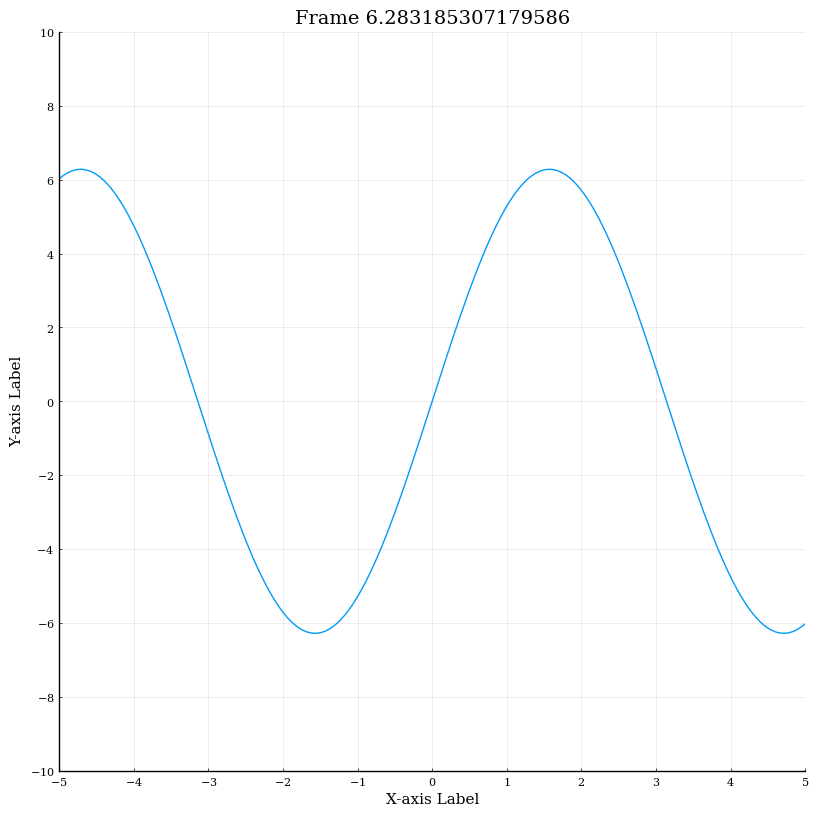

Plots.AnimatedGif("/home/mgadaloff/SAFT_ML/special_thingy_params/tmp.gif")
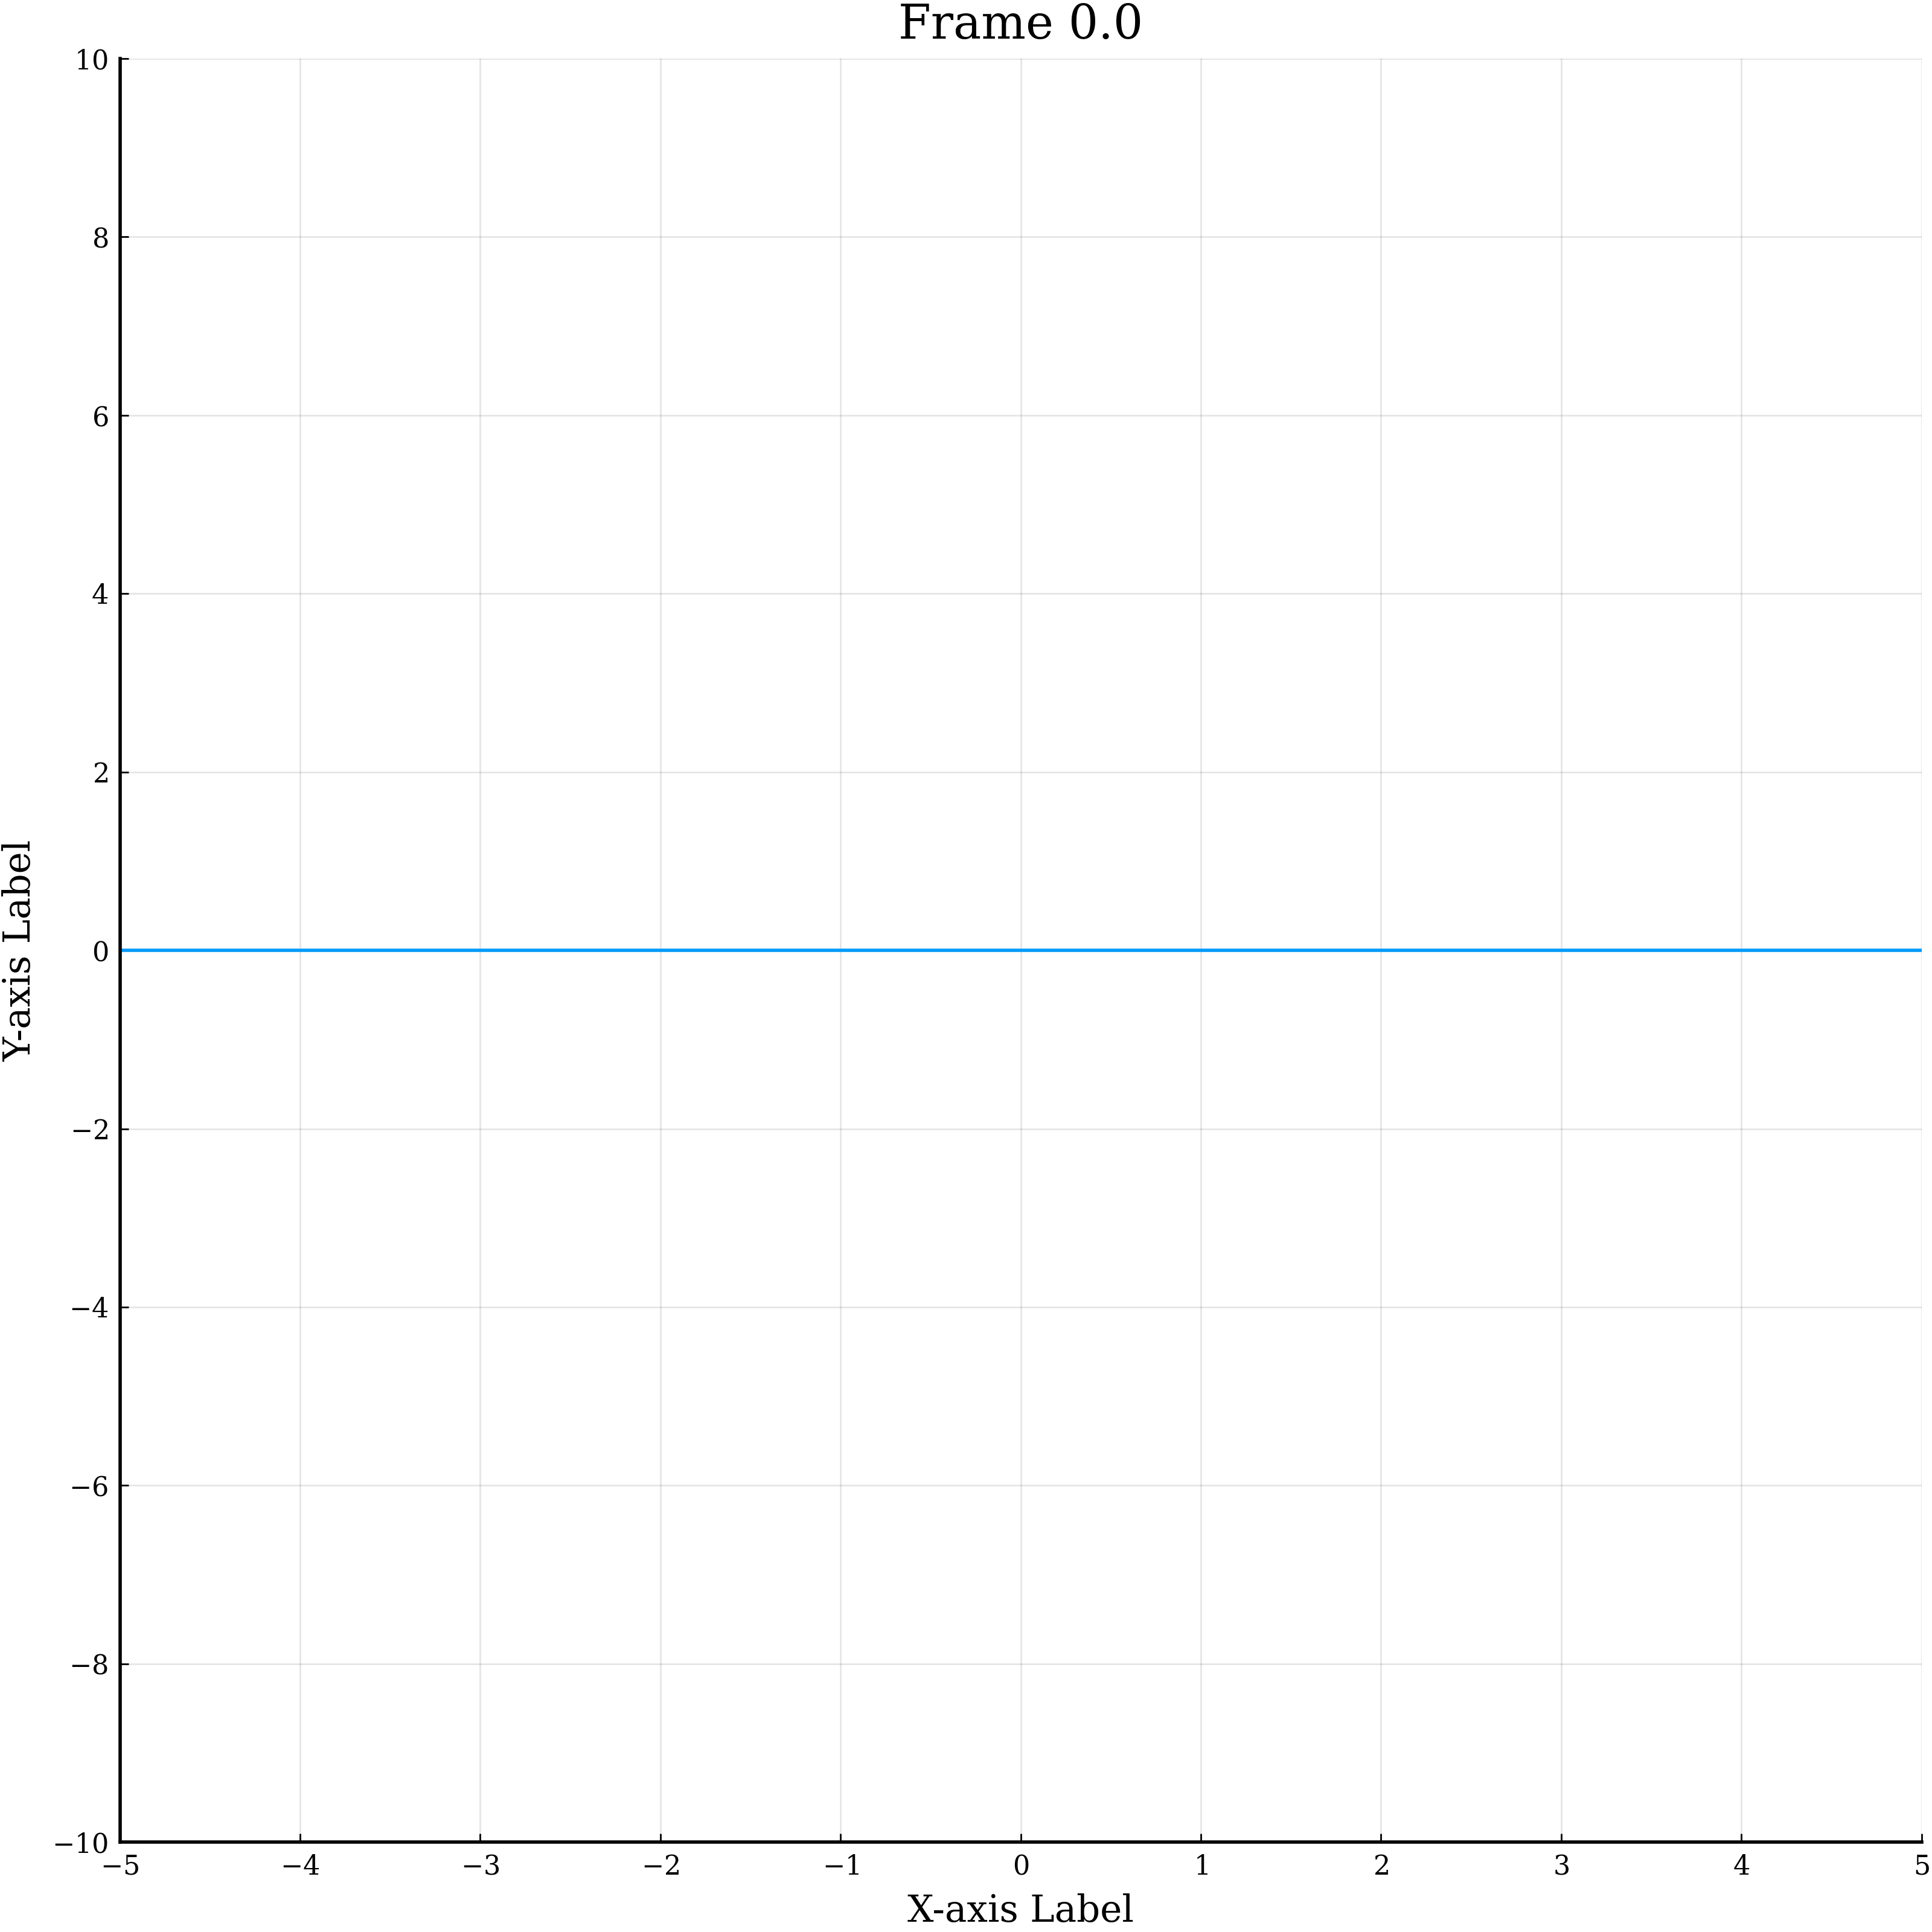

In [9]:
using Plots

pyplot()

default(legend = false)
x = range(-5, 5, length = 200)
n = 10

# Set the font family
fontfamily = "serif"

@gif for i in range(0, stop = 2π, length = n)

    y = i .* sin.(x)

    p = plot(x, y, dpi=400, size=(800,800))
    
    xlabel!("X-axis Label", fontfamily=fontfamily)
    ylabel!("Y-axis Label", fontfamily=fontfamily)
    xlims!(-5, 5)
    xticks!(-5:1:5, fontfamily=fontfamily)
    yticks!(-10:2:10, fontfamily=fontfamily)
    # linewidth!(2)
    # legend!(false, fontfamily=fontfamily)
    title!("Frame $i", fontfamily=fontfamily)
    # titlefontsize!(12, fontfamily=fontfamily)
    # tickfontsize!(10, fontfamily=fontfamily)
    # guidefont!(10, fontfamily)

    ylims!(-10, 10)

    println(i)

end


In [16]:
# Number of frames
num_epochs = 10

# Amplitude values for each frame
amplitudes = range(1, 10, num_epochs)

# Initialize the plot
fig = plot(layout=(1,1), size=(800, 400), dpi=400)

# Function to update the plot for each frame
function update(epoch)

    # Clear the previous plot
    plot!(fig[1], legend=false)

    # Update the data or plot here
    # Plot a sine wave with changing amplitude
    x = 0:0.1:10
    y = amplitudes[epoch] * sin.(x)

    plot!(fig[1], x, y, title="Frame $epoch")
    xlabel!("Test")
    ylabel!("Test")
    xlims!((0,10))
    ylims!((-10,10))

end

# Create the animation
animation = Animation()

for epoch in 1:num_epochs
    println(epoch)
    update(epoch)
    frame(animation)
end

# Display the animation
display(animation)

# Save the animation as a .gif file
gif(animation, "animation.gif")


1


LoadError: BoundsError: attempt to access 0-element Vector{Any} at index [1]

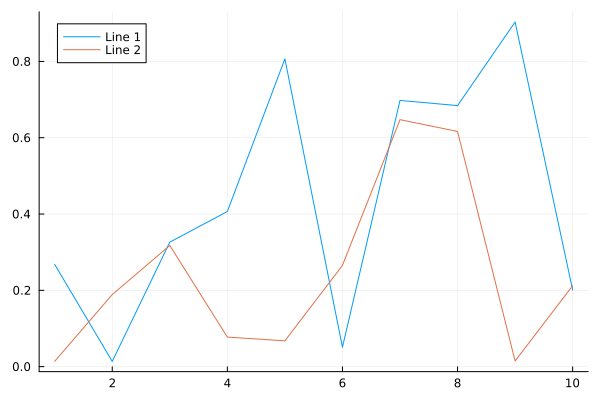

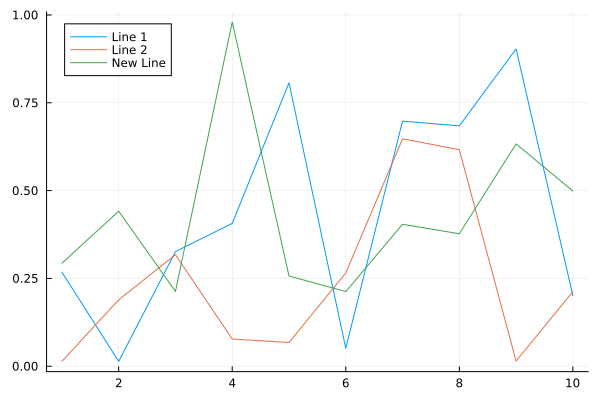

In [37]:
using Plots

# Generate some sample data
x = 1:10
y1 = rand(10)
y2 = rand(10)

# Plot the initial data
plot(x, y1, label="Line 1")
plot!(x, y2, label="Line 2")

# Show the plot
display(Plots.plot!())  # Display the plot in Jupyter or another environment

# Clear the existing plot by creating a new plot object
plot!()  # This creates an empty plot

# Now you can plot new data without the previous lines
y3 = rand(10)
plot!(x, y3, label="New Line")

# Show the updated plot
display(Plots.plot!())  # Display the updated plot


In [37]:
using Plots
default(legend = false)
x = y = range(-5, 5, length = 40)
zs = zeros(0, 40)
n = 100

@gif for i in range(0, stop = 2π, length = n)
    f(x, y) = sin(x + 10sin(i)) + cos(y)

    # create a plot with 3 subplots and a custom layout
    l = @layout [a{0.7w} b; c{0.2h}]
    p = plot(x, y, f, st = [:surface, :contourf], layout = l)

    # induce a slight oscillating camera angle sweep, in degrees (azimuth, altitude)
    plot!(p[1], camera = (10 * (1 + cos(i)), 40))

    # add a tracking line
    fixed_x = zeros(40)
    z = map(f, fixed_x, y)
    plot!(p[1], fixed_x, y, z, line = (:black, 5, 0.2))
    vline!(p[2], [0], line = (:black, 5))

    # add to and show the tracked values over time
    global zs = vcat(zs, z')
    plot!(p[3], zs, alpha = 0.2, palette = cgrad(:blues).colors)
end

LoadError: PyError ($(Expr(:escape, :(ccall(#= /home/mgadaloff/.julia/packages/PyCall/ilqDX/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'TypeError'>
TypeError("'Figure' object is not callable")


In [ ]:
colour_bar_interval = 10
colour_scheme = "viridis"
scatter_plot_size = 15

# This code plots the parameters as tiled figures

figure_1, axes_1 = plt.subplots(1, 3, figsize=(18, 5), dpi=600)
# figure_1.suptitle("Parameter Evolution for Linear Alkanes", fontsize=18, x = 0.38, y=0.975)

figure_2, axes_2 = plt.subplots(2, 3, figsize=(18, 12), dpi=400)
figure_2.suptitle("Parameter Evolution for Linear Alkanes", fontsize=18, x = 0.38, y=0.925)

figure_3, axes_3 = plt.subplots(4, 1, figsize=(18, 22.5), dpi=400)
# figure_3.suptitle("Parameter Evolution for Linear Alkanes", fontsize=18, x = 0.5, y=1)

figure_4, axes_4 = plt.subplots(1, 1, figsize=(8, 6), dpi=400)

color_mapping = collect(range(vmin, vmax))
ideal_Mw = collect(range(0, 500, 500))
species_names = processed_data.species

vr_mie_given_ms = vr_mie_source_params.segment
vr_mie_given_σs = vr_mie_source_params.sigma
vr_mie_given_ϵs = vr_mie_source_params.epsilon
vr_mie_given_λ_rs = vr_mie_source_params.lambda_r
vr_mie_given_Mws = vr_mie_source_params.Mw

pcp_given_ms = pcp_source_params_alkanes.segment
pcp_given_σs = pcp_source_params_alkanes.sigma
pcp_given_ϵs = pcp_source_params_alkanes.epsilon
pcp_given_Mws = pcp_source_params_alkanes.Mw

axes_2[1,1].scatter(vr_mie_given_Mws, vr_mie_given_ms, color="#c40000",marker="^")
axes_2[1,2].scatter(vr_mie_given_Mws, vr_mie_given_σs, color="#c40000",marker="^")
axes_2[2,1].scatter(vr_mie_given_Mws, vr_mie_given_ϵs, color="#c40000",marker="^")
axes_2[2,2].scatter(vr_mie_given_Mws, vr_mie_given_λ_rs, color="#c40000",marker="^")

# axes_2[1,1].scatter(pcp_given_Mws, pcp_given_ms, color="k",marker="^")
# axes_2[1,2].scatter(pcp_given_Mws, pcp_given_σs, color="k",marker="^")
# axes_2[2,1].scatter(pcp_given_Mws, pcp_given_ϵs, color="k",marker="^")

ideal_mσ3s = [1.8975 * i + 18.278 for i in ideal_Mw]
ideal_mϵs = [8.2034 * i + 36.245 for i in ideal_Mw]
current_mσ3s = [lin_fit_coeff_mσ3[2] * i + lin_fit_coeff_mσ3[1] for i in ideal_Mw]
current_mϵs = [lin_fit_coeff_mϵ[2] * i + lin_fit_coeff_mϵ[1] for i in ideal_Mw]

axes_1[1].plot(ideal_Mw, ideal_mσ3s, color="k", "--")
axes_1[1].plot(ideal_Mw, current_mσ3s, color="k")
axes_1[2].plot(ideal_Mw, ideal_mϵs, color="k", "--")
axes_1[2].plot(ideal_Mw, current_mϵs, color="k")

Mw = [] ; mϵ = [] ; species_name = [] ; ms = [] ; σs = []; ϵs = []; λ_rs = [];

for j = 1:nrow(processed_data)

    
    Mw = fill(processed_data[j,:Mw], num_epochs_plotting)
    ms = processed_data[j,:m]
    σs = processed_data[j,:σ]
    ϵs = processed_data[j,:ϵ]
    λ_rs = processed_data[j,:λ_r]
    λ_as = 6
    species_name = fill(species_names[j],num_epochs_plotting)

    mσ3 = [ms[i] * σs[i]^3 for i in 1:num_epochs_plotting]
    mϵ = [ms[i]^1 * ϵs[i] for i in 1:num_epochs_plotting]

    vdw_as = [-2*pi * ((λ_rs[i]/(λ_rs[i] - λ_as))*(λ_rs[i]/λ_as)^(λ_as/(λ_rs[i]-λ_as))) * (ϵs[i] * σs[i]^3 * ms[i]^1 * (1/(λ_rs[i] - 3) - 1/(λ_as-3))) for i in 1:num_epochs_plotting]

    # println(vdw_as)

    axes_1[2].scatter(Mw, mϵ, c=color_mapping, cmap=colour_scheme,s=scatter_plot_size,vmin=vmin,vmax=vmax)
    axes_1[1].scatter(Mw, mσ3, c=color_mapping, cmap=colour_scheme,s=scatter_plot_size,vmin=vmin,vmax=vmax)

    axes_2[1,1].scatter(Mw, ms, c=color_mapping, cmap=colour_scheme,s=scatter_plot_size,vmin=vmin,vmax=vmax)
    axes_2[1,2].scatter(Mw, σs, c=color_mapping, cmap=colour_scheme,s=scatter_plot_size,vmin=vmin,vmax=vmax)
    axes_2[2,1].scatter(Mw, ϵs, c=color_mapping, cmap=colour_scheme,s=scatter_plot_size,vmin=vmin,vmax=vmax)
    axes_2[2,2].scatter(Mw, λ_rs, c=color_mapping, cmap=colour_scheme,s=scatter_plot_size,vmin=vmin,vmax=vmax)

    axes_4.scatter(Mw, vdw_as, c=color_mapping, cmap=colour_scheme,s=scatter_plot_size,vmin=vmin,vmax=vmax)

    axes_3[1,1].scatter(species_name, ms, c=color_mapping, cmap=colour_scheme,s=scatter_plot_size,vmin=vmin,vmax=vmax)
    axes_3[2,1].scatter(species_name, σs, c=color_mapping, cmap=colour_scheme,s=scatter_plot_size,vmin=vmin,vmax=vmax)
    axes_3[3,1].scatter(species_name, ϵs, c=color_mapping, cmap=colour_scheme,s=scatter_plot_size,vmin=vmin,vmax=vmax)
    axes_3[4,1].scatter(species_name, λ_rs, c=color_mapping, cmap=colour_scheme,s=scatter_plot_size,vmin=vmin,vmax=vmax)

end

# Plot 1 details
axes_1[1].set_xlabel("Molar Weight / g mol\$^{-1}\$", fontsize=12)
axes_1[1].set_ylabel("mσ\$^3\$", fontsize=12)
# axes_1[1].set_ylim([0, 800])
axes_1[1].set_xlim([0, 500])

# Find source paper for clapeyron saft-vr-mie params
# axes_1[2].legend(["Lafitte et al. (2013), Hosseinifar et al. (2016)","Current Fit"], loc="lower right", fontsize=8)
axes_1[2].set_xlabel("Molar Weight / g mol\$^{-1}\$", fontsize=12)
axes_1[2].set_ylabel("mϵ", fontsize=12)
# axes_1[2].set_ylim([0, 3000])
axes_1[2].set_xlim([0, 500])

cax = figure_1.add_axes([0.575, 0, 0.07, 1])
cbar = figure_1.colorbar(axes_1[2].scatter(Mw, mϵ, c=color_mapping, cmap=colour_scheme), ax=cax, ticks=vmin:colour_bar_interval:vmax, label="Epoch")
plt.delaxes(cax)
plt.delaxes(axes_1[3])

# Plot 2 details
axes_2[1,1].set_xlabel("Molar Weight / g mol\$^{-1}\$", fontsize=12)
axes_2[1,2].set_xlabel("Molar Weight / g mol\$^{-1}\$", fontsize=12)
axes_2[2,1].set_xlabel("Molar Weight / g mol\$^{-1}\$", fontsize=12)
axes_2[2,2].set_xlabel("Molar Weight / g mol\$^{-1}\$", fontsize=12)

axes_2[1,1].set_ylabel("m", fontsize=12)
axes_2[1,2].set_ylabel("σ", fontsize=12)
axes_2[2,1].set_ylabel("ϵ", fontsize=12)
axes_2[2,2].set_ylabel("λ\$_r\$", fontsize=12)

# axes_2[1,1].set_ylim([1.5, 3.5])
# axes_2[1,2].set_ylim([2, 4])
# axes_2[2,1].set_ylim([200, 300])
# axes_2[2,2].set_ylim([0, 20])

# axes_2[1,1].set_xlim([0, 500])
# axes_2[1,2].set_xlim([0, 500])
# axes_2[2,1].set_xlim([0, 500])
# axes_2[2,2].set_xlim([0, 500])

cax_2 = figure_2.add_axes([0.525, 0, 0.15, 1])
cbar = figure_2.colorbar(axes_1[2].scatter(Mw, mϵ, c=color_mapping, cmap=colour_scheme), ax=cax_2, ticks=vmin:colour_bar_interval:vmax)
cbar[:set_label]("Epoch", size=18, labelpad=20)  # Adjust the labelpad value to change the position

plt.delaxes(cax_2)
plt.delaxes(axes_2[1,3])
plt.delaxes(axes_2[2,3])

# axes_2[1,1].legend(["Lafitte et al. (2013), Hosseinifar et al. (2016)"], loc="upper left", fontsize=8)
axes_2[1,1].legend(["Lafitte et al. (2013), Hosseinifar et al. (2016)"], loc="upper left", fontsize=8)

# Plot 3 details
axes_3[1,1].set_ylabel("m", fontsize=12)
axes_3[2,1].set_ylabel("σ", fontsize=12)
axes_3[3,1].set_ylabel("ϵ", fontsize=12)
axes_3[4,1].set_ylabel("λ\$_r\$", fontsize=12)

for ax in (axes_3[1,1], axes_3[2,1], axes_3[3,1], axes_3[4,1])
    labels = ax.get_xticklabels()
    setp(labels, rotation=50, ha="right")
end

axes_4.set_xlabel("Molar Weight / g mol\$^{-1}\$", fontsize=15)
axes_4.set_ylabel("VdW a", fontsize=15)
# axes_4.set_yticks(ticks=[10], labelsize=15)
# axes_4.set_xticks(axis="x", labelsize=15)
# axes_4.set_yscale("log")

cbar = figure_3.colorbar(axes_3[1,1].scatter(species_name, ms, c=color_mapping, cmap=colour_scheme), ax=axes_3[1,1], ticks=vmin:colour_bar_interval:vmax)
cbar = figure_3.colorbar(axes_3[2,1].scatter(species_name, σs, c=color_mapping, cmap=colour_scheme), ax=axes_3[2,1], ticks=vmin:colour_bar_interval:vmax)
cbar = figure_3.colorbar(axes_3[3,1].scatter(species_name, ϵs, c=color_mapping, cmap=colour_scheme), ax=axes_3[3,1], ticks=vmin:colour_bar_interval:vmax)
cbar = figure_3.colorbar(axes_3[4,1].scatter(species_name, λ_rs, c=color_mapping, cmap=colour_scheme), ax=axes_3[4,1], ticks=vmin:colour_bar_interval:vmax)

# axes_3[1,1].colorbar(ticks = 0:250:num_epochs_plotting,label = "Epoch")

# new_width = 0.5
# current_position = axes_3[1,1].get_position()
# axes_3[1,1].set_position([current_position.x0, current_position.y0, new_width, current_position.height])

tight_layout()

# To save the figure
# plt.savefig("all_compound_phase_envelopes.png", dpi=400)